<a href="https://colab.research.google.com/github/Jshajbc/1122/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import requests
from bs4 import BeautifulSoup
import csv
import re
from PIL import Image
from io import BytesIO
import imghdr

from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import cv2
from random import shuffle

import torch
from torch.utils.data import Dataset
from glob import glob
from os.path import splitext
from os import listdir
import os
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount("/content/drive") # mount your Google Drive; allow the notebook to access the data in your google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/My Drive/UCL skill module/unet_data/" # in-drive data path

os.chdir(dataset_path)
os.listdir(dataset_path)

['ckpts',
 'dst',
 'Map_ST.jpg',
 'Map_LD.jpg',
 'Map_ST.npy',
 'Map_LD.npy',
 'resample']

In [ ]:
!pip install pillow numpy

In [ ]:
from PIL import Image

dataset_path = "/content/drive/My Drive/UCL skill module/unet_data/"

def tiff_to_npy(tiff_path, npy_path):
    with Image.open(tiff_path) as img:
        image_array = np.array(img)
    np.save(npy_path, image_array)
    print(f"Saved {npy_path}")

for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg"):
        full_tiff_path = os.path.join(dataset_path, filename)
        npy_filename = filename.replace('.jpg', '.npy')
        full_npy_path = os.path.join(dataset_path, npy_filename)

        tiff_to_npy(full_tiff_path, full_npy_path)

Saved /content/drive/My Drive/UCL skill module/unet_data/Map_ST.npy
Saved /content/drive/My Drive/UCL skill module/unet_data/Map_LD.npy


In [ ]:
import tqdm

def load_image(input_path, target_path):
    image = np.load(input_path)
    print('image.shape: ', image.shape)
    label = np.load(target_path)
    print('label.shape: ', label.shape, np.unique(label))
    return image, label

input_dir = '/content/drive/My Drive/UCL skill module/unet_data/Map_ST.npy'
target_dir = '/content/drive/My Drive/UCL skill module/unet_data/Map_LD.npy'
image, label = load_image(input_dir, target_dir)


image.shape:  (418, 443, 4)
label.shape:  (418, 443, 4) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232

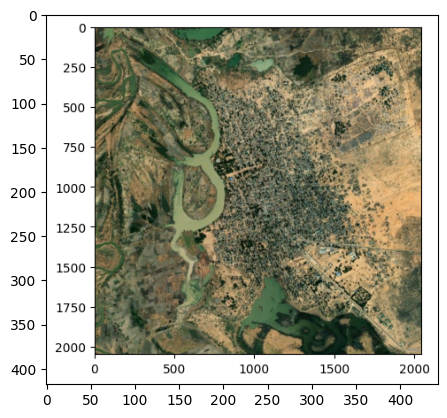

In [ ]:
plt.imshow(image)
plt.show()

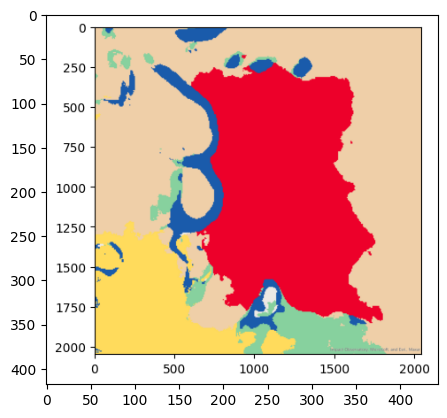

In [ ]:

plt.imshow(label)
plt.show()

In [ ]:

img_save_dir = './resample/{}/src/'.format('train')
target_save_dir = './resample/{}/label/'.format('train')
valid_img_save_dir = './resample/{}/src/'.format('valid')
valid_target_save_dir = './resample/{}/label/'.format('valid')

os.makedirs(img_save_dir, exist_ok=True)
os.makedirs(target_save_dir, exist_ok=True)
os.makedirs(valid_img_save_dir, exist_ok=True)
os.makedirs(valid_target_save_dir, exist_ok=True)

sub_sampling_num = 500
x_crop = 256
y_crop = 256

valid_ratio = 0.2
train_valid_count = {'train samples: ':0, 'valid samples: ':0}

for i in tqdm.tqdm(range(sub_sampling_num)):
    x = np.random.randint(x_crop//2, high=image.shape[0]- x_crop//2)
    y = np.random.randint(y_crop // 2, high=label.shape[0] - y_crop // 2)
    dst_image = image[x-x_crop//2 : x+x_crop//2, y-y_crop//2 : y+y_crop//2, :]
    dst_label = label[x-x_crop//2 : x+x_crop//2, y-y_crop//2 : y+y_crop//2]

    if np.random.random() > valid_ratio:
        np.save(img_save_dir + '{}.npy'.format(i), dst_image)
        np.save(target_save_dir + '{}.npy'.format(i), dst_label)
        train_valid_count['train samples: '] += 1
    else:
        np.save(valid_img_save_dir + '{}.npy'.format(i), dst_image)
        np.save(valid_target_save_dir + '{}.npy'.format(i), dst_label)
        train_valid_count['valid samples: '] += 1

print(train_valid_count)


100%|██████████| 500/500 [00:43<00:00, 11.57it/s]

{'train samples: ': 390, 'valid samples: ': 110}


In [ ]:

class LandUseDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]

    def preprocess(cls, img_nd):
        img_trans = img_nd.transpose((2, 0, 1)) #(256,256,3) -> (3,256,256)
        return img_trans

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        idx = self.ids[index]
        mask_path = self.masks_dir + idx + '.npy'
        img_path = self.imgs_dir + idx + '.npy'
        img = np.load(img_path)
        mask = np.load(mask_path)

        img = self.preprocess(img)
        img = img / 255

        img = torch.from_numpy(img.copy())
        mask = torch.from_numpy(mask.copy())

        return img, mask

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),  # modify the input directly, without allocating any additional output
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1) # batchsize, channel, h, w
        #x2: (8,64,256,256),x1: (8,64,256,256) -> (8,128,256,256)
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


In [ ]:
input = torch.randn((8,3,256,256))
net = UNet(n_channels=3, n_classes=4)
y = net(input)
print(y.size())

torch.Size([8, 4, 256, 256])


In [ ]:
import argparse


def get_unet_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('-e', '--epochs', metavar='E', type=int, default=21,
                        help='Number of epochs', dest='epochs')
    parser.add_argument('-b', '--batch-size', metavar='B', type=int, nargs='?', default=4,
                        help='Batch size', dest='batchsize')
    parser.add_argument('-l', '--learning-rate', metavar='LR', type=float, nargs='?', default=5e-4,
                        help='Learning rate', dest='lr')
    parser.add_argument('-f', '--load', dest='load', type=str, default=False,
                        help='Load model from a .pth file')

    return parser.parse_args()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
def train_net(net = UNet, device = torch.device('cuda'),
              epochs=5, batch_size=1, lr=0.1, save_cp=True):

    dir_checkpoint = dataset_path + "ckpts/"
    os.makedirs(dir_checkpoint, exist_ok=True)

    dataset_dir = "/content/drive/My Drive/UCL skill module/unet_data/resample/"
    # step 1
    train_dir = dataset_dir + "train/"
    valid_dir = dataset_dir + "valid/"


    # step 2
    train_data = LandUseDataset(imgs_dir = train_dir + 'src/', masks_dir = train_dir +'label/')
    valid_data = LandUseDataset(imgs_dir = valid_dir + 'src/', masks_dir = valid_dir +'label/')

    # step 3
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
    valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size)

    optimizer = optim.Adam(net.parameters(), lr, (0.9, 0.999))
    criterion = nn.CrossEntropyLoss()  # BCELOSS (Binary Cross Entropy) for binary classification

    train_acc_list = []
    valid_acc_list = []
    train_epoch = []
    valid_epoch = []

    for epoch in range(0, epochs):

        # ---------------------------------------- train ----------------------------------------

        net.train()
        epoch_loss = 0
        acc = 0
        train_record = {'train_loss': 0, 'train_acc': 0}

        for i, (imgs, true_masks) in enumerate(train_loader):
            imgs = Variable(imgs).to(device=device, dtype=torch.float32)  # device: cpu?gpu?
            true_masks = Variable(true_masks).to(device=device, dtype=torch.int64)

            optimizer.zero_grad()

            masks_pred = net(imgs)
            loss = criterion(masks_pred, true_masks)
            epoch_loss += loss.item()

            # Backprop + optimize
            loss.backward()
            optimizer.step()

            # get acc
            _, masks_pred_max = torch.max(masks_pred.data, 1)
            corr = torch.sum(masks_pred_max == true_masks.detach())
            tensor_size = masks_pred_max.size(0) * masks_pred_max.size(1) * masks_pred_max.size(2)
            acc += float(corr) / float(tensor_size)
            batch_acc = acc/(i+1)

            train_record['train_loss'] += loss.item()
            train_record['train_acc'] += batch_acc

            if i % (2 * batch_size) == 0:
                print('Epoch [{} / {}], batch: {}, train loss: {}, train acc: {}'.format(epoch+1,epochs, i+1, loss.item(), batch_acc))

        train_record['train_loss'] = train_record['train_loss'] / len(train_loader)
        train_record['train_acc'] = train_record['train_acc'] / len(train_loader)

        train_acc_list.append(train_record['train_acc'])
        train_epoch.append(epoch+1)

        print(train_record)

        # ===================================== Validation ====================================#
        net.eval()

        val_acc = 0
        val_record = {'val_loss': 0, 'val_acc': 0}

        for i, (imgs, true_masks) in enumerate(valid_loader):
            imgs = imgs.to(device=device, dtype=torch.float32)
            val_masks = true_masks.to(device=device, dtype=torch.int64)
            val_pred = net(imgs)
            val_loss = criterion(val_pred, val_masks)

            _, val_pred_max = torch.max(val_pred.data, 1)
            corr = torch.sum(val_pred_max == val_masks.detach())
            tensor_size = val_pred_max.size(0) * val_pred_max.size(1) * val_pred_max.size(2)
            val_acc += float(corr) / float(tensor_size)
            val_batch_acc = val_acc / (i + 1)

            val_record['val_loss'] += val_loss.item()
            val_record['val_acc'] += val_batch_acc

        val_record['val_loss'] = val_record['val_loss'] / len(valid_loader)
        val_record['val_acc'] = val_record['val_acc'] / len(valid_loader)

        valid_acc_list.append(val_record['val_acc'])
        valid_epoch.append(epoch + 1)

        print(val_record)
        print('----------------------------------------------------------------------------------------------------')

        if save_cp:
            os.makedirs(dir_checkpoint, exist_ok=True)
            if epoch % 5 == 0:
                torch.save(net.state_dict(), dir_checkpoint + f'CP_epoch{epoch}.pth')

    #----------------------------------------- plot acc curves -------------------------------------------------------
    plt.plot(train_epoch, train_acc_list, label = "train acc")
    plt.plot(valid_epoch, valid_acc_list, label="valid acc")
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

net = UNet(n_channels= 3, n_classes=4)
net.to(device)

args = get_unet_args()
train_net(net=net,epochs=args.epochs,batch_size=args.batchsize,lr=args.lr,device=device,save_cp= True)
     = True)


IndentationError: unexpected indent (<ipython-input-128-e7dcbf91901b>, line 9)

In [ ]:

def color_annotation(image):
    color = np.ones([image.shape[0], image.shape[1], 3])
    color[image == 0] = [0, 0, 0]  # bg
    color[image == 1] = [204, 104, 0]  # water
    color[image == 2] = [0, 153, 0]  # vegatation
    color[image == 3] = [102, 0, 204]  # urban extent
    return color

In [ ]:

def predict_img(net, img, device = torch.device('cuda')):
    net.eval()
    img = img.transpose((2, 0, 1))
    img = img / 255
    img = torch.from_numpy(img)
    img = img.unsqueeze(0) # add batch dimention
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)
        probs = F.softmax(output, dim=1)
        probs = torch.max(probs.squeeze(0), dim=0) # torch.max returns a tuple (max_values, indices)
        predict = probs[1].cpu().numpy()

    return predict

In [ ]:
def get_subsample_centroids(img, img_size=256):
    h_total = img.shape[0]
    w_total = img.shape[1]
    h_step = int(h_total // img_size * 2)
    w_step = int(w_total // img_size * 2)
    x_list = np.linspace(img_size//2, h_total-img_size//2, num=h_step)
    y_list = np.linspace(img_size//2, w_total -img_size//2, num=w_step)

    new_x_list = []
    new_y_list = []

    for i in x_list:
        for j in y_list:
            new_x_list.append(int(i))
            new_y_list.append(int(j))

    return zip(new_x_list, new_y_list)

In [ ]:
dir_checkpoint = dataset_path + "ckpts/"
model_name = 'CP_epoch20.pth'
file_name = dataset_path + 'ori_data/img.npy'
save_dir = dataset_path + 'dst/'
os.makedirs(save_dir, exist_ok=True)

out_path = save_dir + 'predict.png'

net = UNet(n_channels=3, n_classes=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)
net.load_state_dict(torch.load(dir_checkpoint + model_name, map_location=device))

img = np.load(file_name)
print(img.shape)

subsample_size = 256
x_y_list = get_subsample_centroids(img, img_size=subsample_size)

sub_imgs = []
for x,y in x_y_list:
    sub_img = img[x - subsample_size//2: x + subsample_size//2,
              y - subsample_size//2 : y + subsample_size//2, :]
    sub_imgs.append(sub_img)

predict_list = []
for sm in sub_imgs:
    predict = predict_img(net=net, img=sm, device=device)
    predict =np.squeeze(predict)  # remove batch dimention
    predict_list.append(predict)

msk = np.zeros((img.shape[0], img.shape[1]))

x_y_list = get_subsample_centroids(img, img_size=subsample_size)

crop_size = subsample_size // 2
# crop_size = 100

for i, (x, y) in enumerate(x_y_list):
    msk[x - crop_size: x + crop_size, y - crop_size : y + crop_size] = predict_list[i]#[28:256-28,28:256-28]

predict_image = color_annotation(msk).astype(np.uint8)
cv2.imwrite(out_path, predict_image)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/UCL skill module/unet_data/ckpts/CP_epoch20.pth'

In [ ]:
plt.imshow(img)
plt.show()

plt.imshow(np.load(dataset_path + 'ori_data/label.npy'))
plt.show()

plt.imshow(msk)
plt.show()

NameError: name 'img' is not defined